In [2]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, r2_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
from tpot import TPOTClassifier
from dask.distributed import Client
import shap

import warnings
warnings.filterwarnings('ignore')

def warn(*args, **kwargs): #suppress scikit-learn warnings
    pass

warnings.warn = warn

In [3]:
df = pd.read_csv('movie_metadata.csv')
df.head()

# movie dataset from https://data.world/popculture/imdb-5000-movie-dataset

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
df.shape

(5043, 28)

In [5]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

There are a total of 5043 entries and 28 columns. There are many entries with missing values including 'gross' which is the going to be the target. Another potential issue with this data is that there are several categories with Facebook related information, ie. movie_facebook_likes but there are many movies that were released before Facebook's time.

## Cleaning Dataset

In [7]:
# Facebook began in 2004, since we might be looking at Facebook likes, we start with movies from 2005
df.loc[df.title_year>2004.0, 'movie_title'].count()

2646

In [8]:
# find any null value in 'gross'
df.loc[df.title_year>2004.0, 'gross'].isna().sum()

490

In [9]:
# find any null value in 'budget'
df.loc[df.title_year>2004.0, 'budget'].isna().sum()

286

In [10]:
# drop movies before 2005
df1 = df.drop(df.loc[df.title_year<2005.0].index, axis=0)

In [11]:
# drop all rows with null in 'gross' or 'budget'
df1.drop(df1.loc[df1['gross'].isna()].index, axis=0, inplace=True)
df1.drop(df1.loc[df1['budget'].isna()].index, axis=0, inplace=True)

In [12]:
sum(df1.apply(lambda x: x.count(), axis=1)<25) #number of rows with more than 3 nan values

5

In [13]:
# find how many 0 values in the various facebook_likes features
print('Movie Facebook Likes: {}'.format(sum(df1.movie_facebook_likes==0)))
print('Director Facebook Likes: {}'.format(sum(df1.director_facebook_likes==0)))
print('Actor 1 Facebook Likes: {}'.format(sum(df1.actor_1_facebook_likes==0)))
print('Actor 2 Facebook Likes: {}'.format(sum(df1.actor_2_facebook_likes==0)))
print('Actor 3 Facebook Likes: {}'.format(sum(df1.actor_3_facebook_likes==0)))
print('Cast Total Facebook Likes: {}'.format(sum(df1.cast_total_facebook_likes==0)))

Movie Facebook Likes: 797
Director Facebook Likes: 321
Actor 1 Facebook Likes: 5
Actor 2 Facebook Likes: 11
Actor 3 Facebook Likes: 20
Cast Total Facebook Likes: 7


The number of movie and director Facebook likes with zero likes is abnormally high considering that all the older movies are no longer in the data. There is no explanation from the data source why such a large number of movies and director got no likes.

In [14]:
# drop features that we won't use
df2=df1.drop(['color', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'aspect_ratio', 'director_name'], axis=1)

In [15]:
df2.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,4834,0.0,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,48350,0.0,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,11700,1.0,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,106759,0.0,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000
5,462.0,132.0,475.0,530.0,640.0,73058679.0,Action|Adventure|Sci-Fi,John Carter,212204,1873,1.0,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000


Many of the movies have multiple genres, ie. action|adventure|sci-fi. This feature has to be encoded properly as categorial data.

In [16]:
# function to create a separate column for each movie genre
df2['Action']=np.zeros([1966, 1])
df2['Adventure']=np.zeros([1966, 1])
df2['Animation']=np.zeros([1966, 1])
df2['Biography']=np.zeros([1966, 1])
df2['Comedy']=np.zeros([1966, 1])
df2['Crime']=np.zeros([1966, 1])
df2['Documentary']=np.zeros([1966, 1])
df2['Drama']=np.zeros([1966, 1])
df2['Fantasy']=np.zeros([1966, 1])
df2['Horror']=np.zeros([1966, 1])
df2['Mystery']=np.zeros([1966, 1])
df2['Romance']=np.zeros([1966, 1])
df2['Sci-Fi']=np.zeros([1966, 1])
df2['Thriller']=np.zeros([1966, 1])
df2['Western']=np.zeros([1966, 1])

for index, entry in enumerate(df2.genres):
    string=[]
    string=entry.split('|')
    for i in string:
        if i=='Action':
            df2.Action[index]=1
        elif i=='Adventure':
            df2.Adventure[index]=1
        elif i=='Animation':
            df2.Animation[index]=1
        elif i=='Biography':
            df2.Biography[index]=1
        elif i=='Comedy':
            df2.Comedy[index]=1
        elif i=='Crime':
            df2.Crime[index]=1
        elif i=='Documentary':
            df2.Documentary[index]=1
        elif i=='Drama':
            df2.Drama[index]=1
        elif i=='Fantasy':
            df2.Fantasy[index]=1
        elif i=='Horror':
            df2.Horror[index]=1
        elif i=='Mystery':
            df2.Mystery[index]=1
        elif i=='Romance':
            df2.Romance[index]=1
        elif i=='Sci-Fi':
            df2['Sci-Fi'][index]=1    
        elif i=='Thriller':
            df2.Thriller[index]=1
        elif i=='Western':
            df2.Western[index]=1

df2.drop('genres', axis=1, inplace=True)

In [17]:
# eliminate duplicates in "movie_title"
df2.drop_duplicates('movie_title', inplace=True)

In [18]:
df2.isnull().sum()

num_critic_for_reviews        1
duration                      1
director_facebook_likes       0
actor_3_facebook_likes        5
actor_1_facebook_likes        2
gross                         0
movie_title                   0
num_voted_users               0
cast_total_facebook_likes     0
facenumber_in_poster          6
num_user_for_reviews          0
language                      2
country                       0
content_rating               29
budget                        0
title_year                    0
actor_2_facebook_likes        4
imdb_score                    0
movie_facebook_likes          0
Action                        0
Adventure                     0
Animation                     0
Biography                     0
Comedy                        0
Crime                         0
Documentary                   0
Drama                         0
Fantasy                       0
Horror                        0
Mystery                       0
Romance                       0
Sci-Fi  

Except for content_rating, only a few categories have 6 or less missing values.

In [19]:
df2['language'].fillna("English", inplace=True) # fill with the most popular language
df2['content_rating'].fillna("Not Rated", inplace=True) 

In [20]:
# examine content_rating column
df2.content_rating.value_counts()

R            786
PG-13        734
PG           273
Not Rated     61
G             33
Unrated       10
NC-17          2
Name: content_rating, dtype: int64

In [21]:
df2.content_rating.replace('Unrated', 'Not Rated', inplace=True) # merge similar categories into one

In [22]:
# display the country origin of the movies
df2.country.value_counts()

USA               1477
UK                 155
France              60
Germany             39
Canada              33
Australia           16
Spain               15
China               11
India               10
Mexico               7
Hong Kong            7
South Korea          6
Denmark              6
Japan                5
New Zealand          5
Ireland              5
Thailand             3
Brazil               3
South Africa         3
Norway               3
Italy                3
Israel               3
Hungary              2
Russia               2
Belgium              2
Czech Republic       2
Netherlands          2
Iceland              2
Iran                 1
Taiwan               1
Chile                1
Indonesia            1
Finland              1
Romania              1
Georgia              1
Poland               1
Argentina            1
Official site        1
Philippines          1
Greece               1
Name: country, dtype: int64

In [23]:
# label encode content_rating, language and country
content_series=pd.Series(df2.content_rating)
cat_content=content_series.astype('category')
df2['content_rating_encoded']=cat_content.cat.codes

language_series=pd.Series(df2.language)
cat_language=language_series.astype('category')
df2['language_encoded']=cat_language.cat.codes

country_series=pd.Series(df2.country)
cat_country=country_series.astype('category')
df2['country_encoded']=cat_country.cat.codes

In [24]:
# eliminate content_rating, language and country
df2.drop(['content_rating', 'language', 'country'], axis=1, inplace=True)

In [25]:
df2.fillna(df2.mean(), inplace=True) # fill missing values with the mean value of the columns

In [26]:
df2.isnull().sum()

num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
gross                        0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
num_user_for_reviews         0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
Action                       0
Adventure                    0
Animation                    0
Biography                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Fantasy                      0
Horror                       0
Mystery                      0
Romance                      0
Sci-Fi                       0
Thriller                     0
Western                      0
content_rating_encoded       0
language

In [27]:
df2.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,Western,content_rating_encoded,language_encoded,country_encoded
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1.899000e+03,1.899000e+03,1899.000000,1899.000000,1899.000000,...,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000
mean,216.653846,108.543203,693.081622,931.385956,8593.687928,5.334825e+07,1.081380e+05,13010.191153,1.533016,311.743549,...,0.007372,0.003160,0.004739,0.003160,0.000527,0.001053,0.000527,4.122696,8.487098,35.379147
std,138.953244,19.225753,2860.078113,2336.297532,13549.243342,7.519024e+07,1.435578e+05,18830.232791,2.388194,383.957140,...,0.085568,0.056136,0.068698,0.056136,0.022948,0.032444,0.022948,0.990048,2.885452,9.479361
min,1.000000,41.000000,0.000000,0.000000,0.000000,1.620000e+02,2.200000e+01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.000000,95.000000,12.000000,187.500000,771.500000,5.725608e+06,2.139500e+04,1949.500000,0.000000,100.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,39.000000
50%,191.000000,105.000000,64.000000,437.000000,2000.000000,2.782987e+07,5.929700e+04,4774.000000,1.000000,195.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,39.000000
75%,288.000000,118.000000,212.000000,729.500000,14000.000000,6.700586e+07,1.368170e+05,18662.500000,2.000000,376.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,39.000000
max,813.000000,240.000000,23000.000000,23000.000000,260000.000000,7.605058e+08,1.676169e+06,303717.000000,43.000000,4667.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,33.000000,39.000000


## Visualizing Data

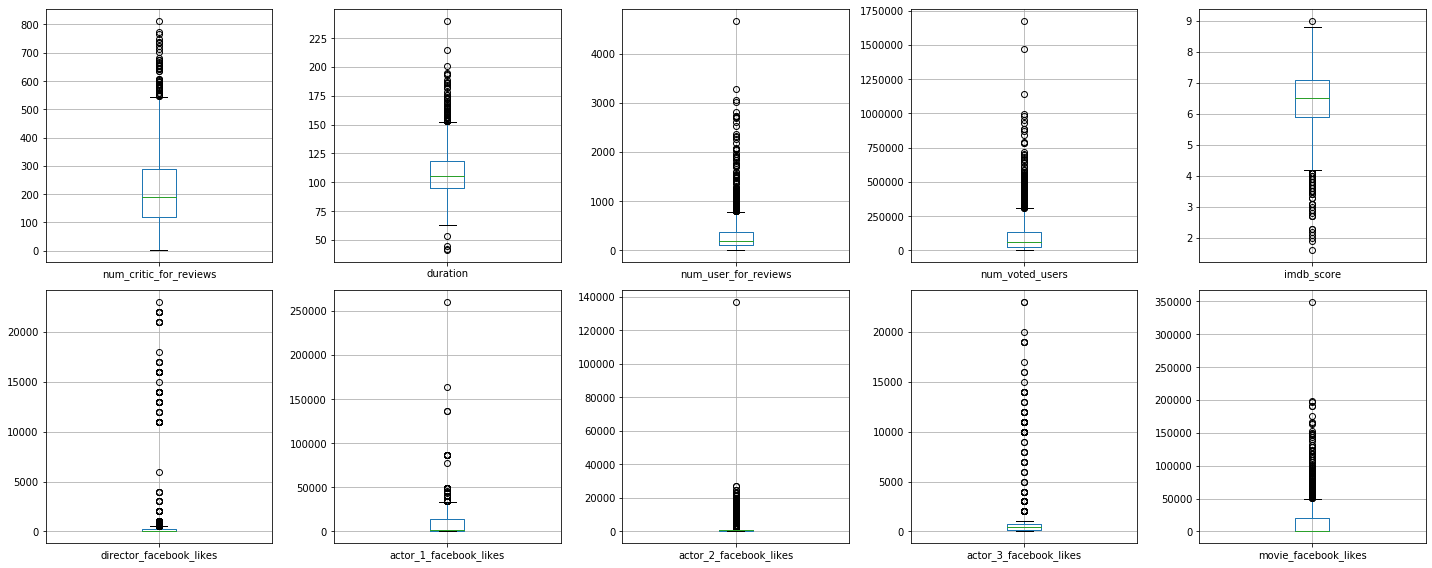

In [28]:
# create boxplot of 10 non-catergorical features
plotdata = df2[['num_critic_for_reviews', 'duration', 'num_user_for_reviews', 'num_voted_users', 'imdb_score', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'movie_facebook_likes']]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # create figure and axes

for i, el in enumerate(list(plotdata.columns.values)[:]):
    a = plotdata.boxplot(el, ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

All of the boxplots except for imdb_score are skewed to higher values. This hints that some kind of data tranformation is warrant in these cases.

In [29]:
# log transform features with extreme skewness
(df2[['log_num_user_for_reviews', 'log_num_voted_users', 'log_director_facebook_likes', 
      'log_actor_1_facebook_likes', 'log_actor_2_facebook_likes', 'log_actor_3_facebook_likes', 
      'log_movie_facebook_likes', 'log_cast_total_facebook_likes']]) = (df2[['num_user_for_reviews', 
      'num_voted_users', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 
      'actor_3_facebook_likes', 'movie_facebook_likes', 'cast_total_facebook_likes']].
      transform(lambda x: np.log(x+1)))

# square root transform features with less severe skewness
df2[['sqrt_num_critic_for_reviews', 'sqrt_duration', 'sqrt_budget']] = df2[['num_critic_for_reviews', 'duration', 'budget']].transform(lambda x: np.sqrt(x))

df2.drop(['num_critic_for_reviews', 'duration', 'num_user_for_reviews', 'num_voted_users', 
          'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 
          'actor_3_facebook_likes', 'movie_facebook_likes', 'cast_total_facebook_likes'], axis=1, inplace=True)

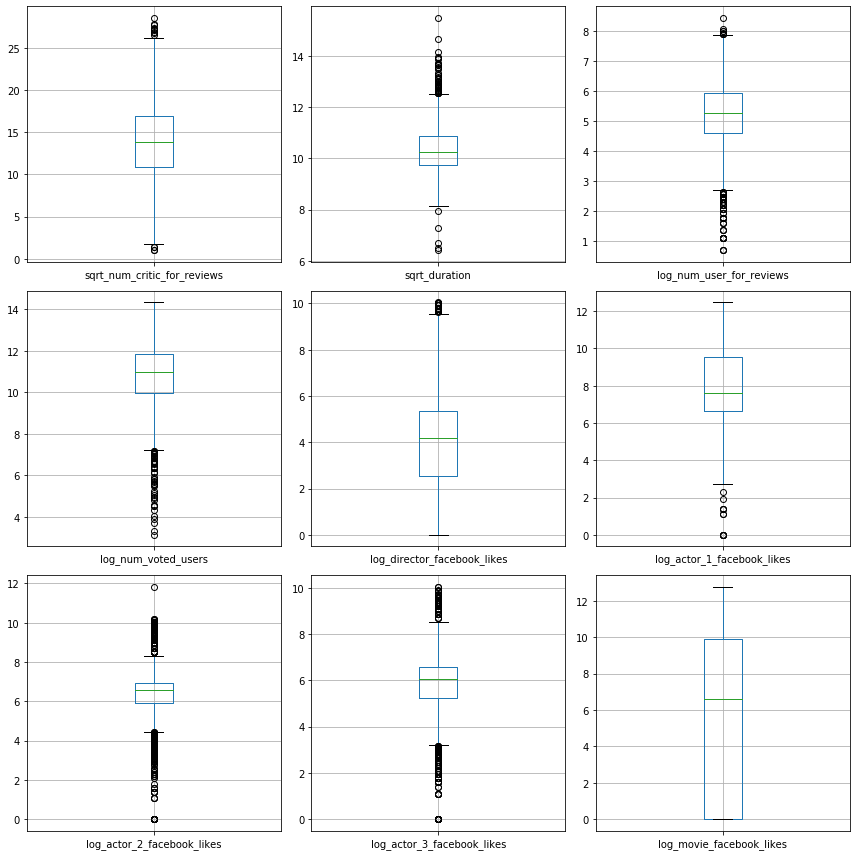

In [30]:
# examine boxplots for improvement after transformation
plotdata = (df2[['sqrt_num_critic_for_reviews', 'sqrt_duration', 'log_num_user_for_reviews', 
                 'log_num_voted_users', 'log_director_facebook_likes', 'log_actor_1_facebook_likes', 
                 'log_actor_2_facebook_likes', 'log_actor_3_facebook_likes', 'log_movie_facebook_likes']])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12)) # create figure and axes

for i, el in enumerate(list(plotdata.columns.values)[:]):
    a = plotdata.boxplot(el, ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

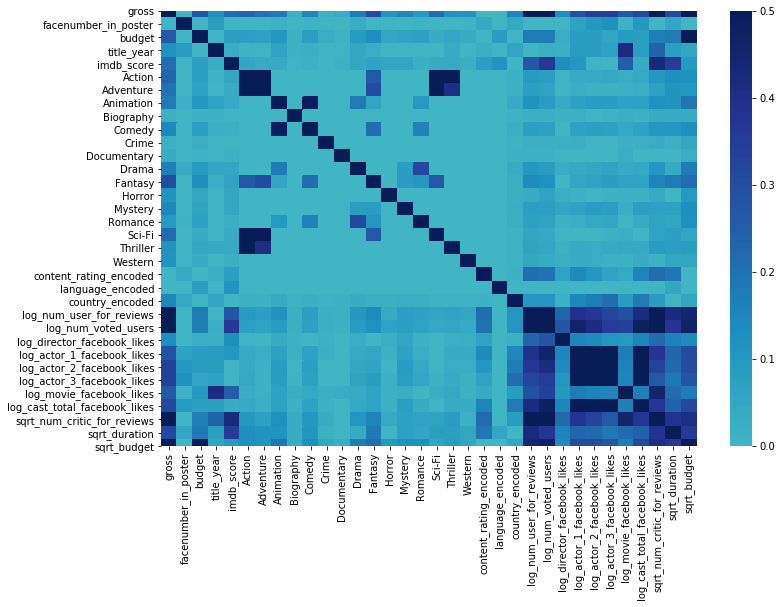

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df2.corr(), center=0, ax=ax, cmap="YlGnBu", vmin=0, vmax=0.1)

It appears that there is some correlation among the newly transformed data, albeit minor.

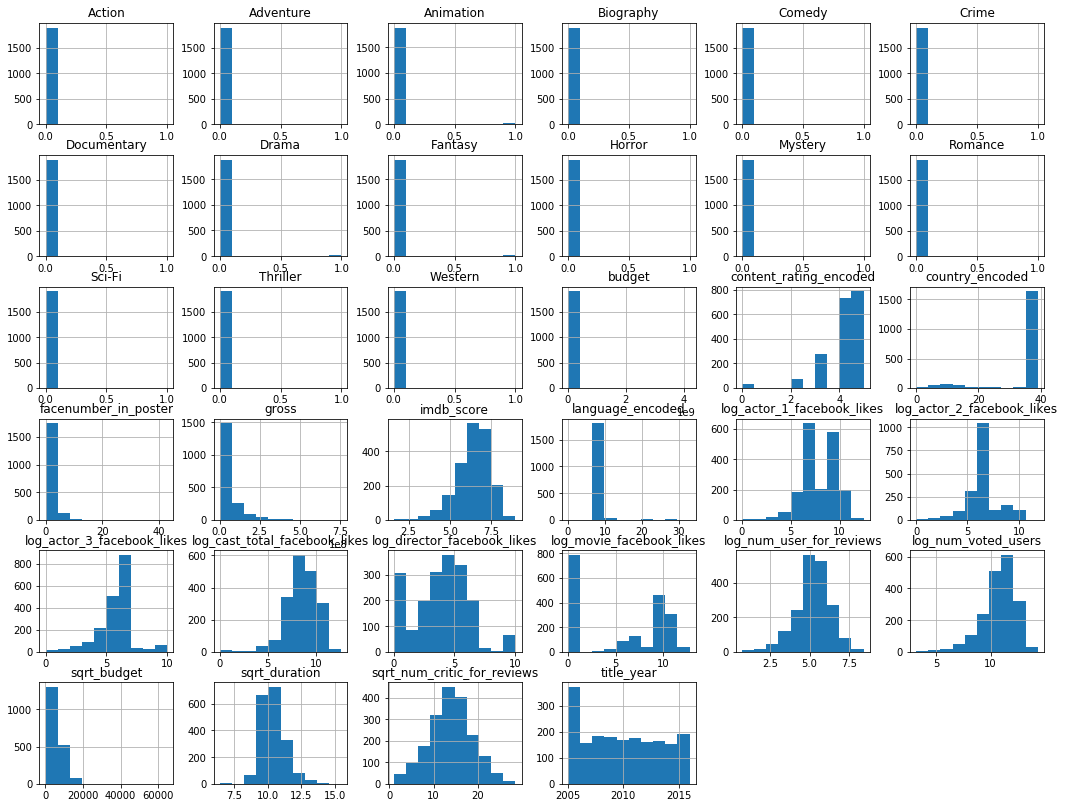

In [32]:
# histograms of every feature
fig = plt.figure(figsize = (18,14))
ax = fig.gca()
df2.hist(ax = ax);

The data transformation made the features more normally distributed

## Creating Feature Inputs and Target for Modelling 

There are many ways to define if a movie is a box office success. The gross revenue is a good indicator but it does not take into account if the movie is also profitable. A movie can be a blockbuster in the theaters bringing in tens of millions of dollars and still not be profitable. In order to provide a more accurate definition, movies that made twice or more than the movie budget are considered a successful here.

In [34]:
y=(df2.gross>=2*df2.budget) # create our target
# create our X
X=df2.drop(['gross', 'budget', 'movie_title'], axis=1)
print(f'{y.sum()} out of {len(y)} movies are successful.')

447 out of 1899 movies are successful.


There is a slight class imbalance in the dataset. Only 24% of the movies are successful. This may lead to a higher false negative rate as successful movies are classified as unsuccessful.

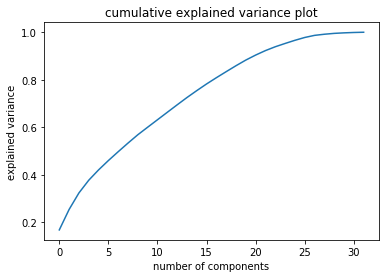

In [48]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pca = pca_pipeline.fit(X)

pca1 = pca.steps[1][1] # this grabs the pca function in the pipeline
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.title('cumulative explained variance plot')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

Unfortunately, the top principle components do not account for the majority of essential characteristics of the data. A plot of the 2 main principal components would not be helpful to understand the features.

In [35]:
# create a train, validation and test set for modelling
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=88, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.2, random_state=88, shuffle=False)

# Baseline Model

### Logistic Regression

In [34]:
logreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', 
                  LogisticRegression(fit_intercept = False, C = 1e12, random_state=100))])

model_logreg = logreg_pipeline.fit(X_train, y_train)

y_hat_train = logreg_pipeline.predict(X_train)
y_hat_val = logreg_pipeline.predict(X_val)

In [34]:
def display_matrix(actual_y, prediction_y, data='Training Set', method='Classifier'):
    
    """
    create an confusion matrix plot given the actual and predicted values of the target
    and prints the classification report.
    """
    
    cf = confusion_matrix(actual_y, prediction_y)
    
    if data == 'Training Set':
        plt.imshow(cf, cmap=plt.cm.Purples)
    else:
        plt.imshow(cf, cmap=plt.cm.Greens)
    
    plt.title(f'Confusion Matrix for {data}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    class_names = set(y)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cf.max() / 2.

    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
            plt.text(j, i, cf[i, j],
                 horizontalalignment="center",
                 color="white" if cf[i, j] > thresh else "black")

    
    plt.colorbar()

    print(f'Classification Report for {data}:\n')
    print(classification_report(actual_y, prediction_y))
    print("{} Accuracy for {}: {:.4}%".format(data, method, accuracy_score(actual_y, prediction_y) * 100))

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.84      0.93      0.88       922
        True       0.67      0.44      0.53       293

    accuracy                           0.81      1215
   macro avg       0.76      0.69      0.71      1215
weighted avg       0.80      0.81      0.80      1215

Training Set Accuracy for Logistic Regression: 81.32%


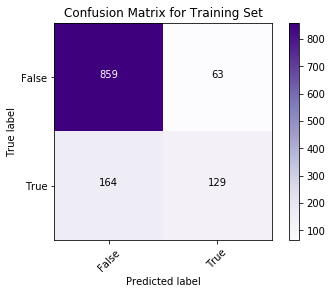

In [36]:
display_matrix(y_train, y_hat_train, data='Training Set', method='Logistic Regression')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.88      0.94      0.91       239
        True       0.69      0.52      0.60        65

    accuracy                           0.85       304
   macro avg       0.79      0.73      0.75       304
weighted avg       0.84      0.85      0.84       304

Validation Set Accuracy for Logistic Regression: 84.87%


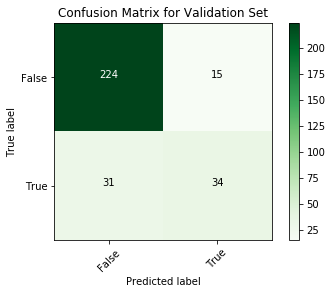

In [37]:
display_matrix(y_val, y_hat_val, data='Validation Set', method='Logistic Regression')

In [35]:
def roc_graph(actual_y, prediction_y):
    
    """
    create a ROC curve given the actual and predicted values of the target
    """
    
    fpr, tpr, threshold = roc_curve(actual_y, prediction_y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

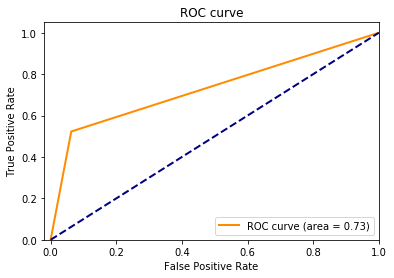

In [39]:
roc_graph(y_val, y_hat_val)

Good predictions for a baseline. There are more false negatives than false positives in validation but the number of accurately predicted positives is higher than any one of the incorrectly predicted categories. An AUC of 0.73 is definitely a great value for a first model.

### Logistic Regression with L1 Regularization and weights

In [40]:
reglogreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(fit_intercept = False, C = 1e12, penalty='l1', class_weight={1:2, 0:1}, random_state=100))])
model_reglogreg = reglogreg_pipeline.fit(X_train, y_train)
y_hat_train1 = reglogreg_pipeline.predict(X_train)
y_hat_val1 = reglogreg_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.90      0.79      0.84       922
        True       0.52      0.72      0.60       293

    accuracy                           0.77      1215
   macro avg       0.71      0.75      0.72      1215
weighted avg       0.81      0.77      0.78      1215

Training Set Accuracy for regularized Logistic Regression: 77.12%


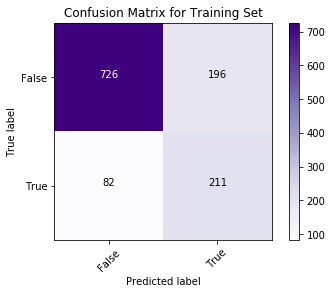

In [41]:
display_matrix(y_train, y_hat_train1, data='Training Set', method='regularized Logistic Regression')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.92      0.80      0.86       239
        True       0.51      0.75      0.61        65

    accuracy                           0.79       304
   macro avg       0.72      0.78      0.73       304
weighted avg       0.83      0.79      0.81       304

Validation Set Accuracy for regularized Logistic Regression: 79.28%


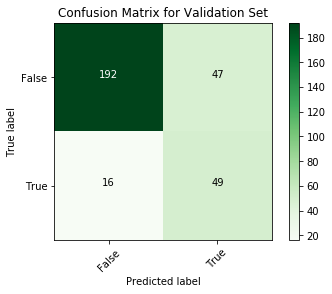

In [42]:
display_matrix(y_val, y_hat_val1, data='Validation Set', method='regularized Logistic Regression')

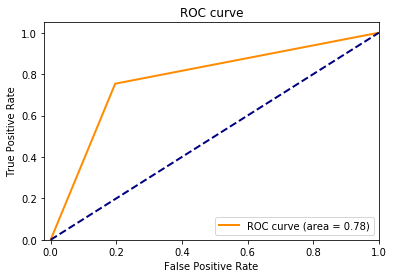

In [43]:
roc_graph(y_val, y_hat_val1)

The good news here is that the false negatives decreased and the accurately predicted positives increased in the validation set. However, there are also more movies that are incorrectly predicted as successful. 

### Logistic Regression with Weights

In [44]:
wlogreg_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(fit_intercept = False, C = 1e12, class_weight={1:2, 0:1}, random_state=100))])
model_wlogreg = wlogreg_pipeline.fit(X_train, y_train)
y_hat_train2 = wlogreg_pipeline.predict(X_train)
y_hat_val2 = wlogreg_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.89      0.84      0.86       922
        True       0.57      0.66      0.61       293

    accuracy                           0.80      1215
   macro avg       0.73      0.75      0.74      1215
weighted avg       0.81      0.80      0.80      1215

Training Set Accuracy for Logistic Regression with weights: 80.0%


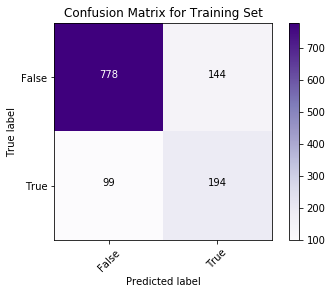

In [45]:
display_matrix(y_train, y_hat_train2, data='Training Set', method='Logistic Regression with weights')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.90      0.86      0.88       239
        True       0.57      0.66      0.61        65

    accuracy                           0.82       304
   macro avg       0.73      0.76      0.75       304
weighted avg       0.83      0.82      0.82       304

Validation Set Accuracy for Logistic Regression with weights: 81.91%


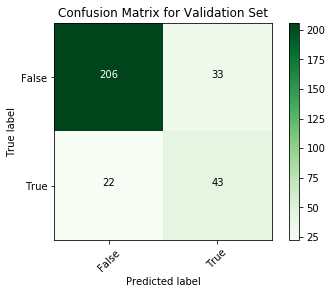

In [46]:
display_matrix(y_val, y_hat_val2, data='Validation Set', method='Logistic Regression with weights')

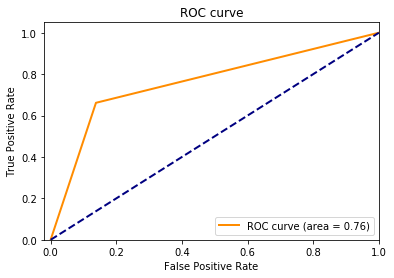

In [47]:
roc_graph(y_val, y_hat_val2)

It appears that the previous regularized model gave better predictions with a slightly larger AUC. The precision score for the minority class here however also went up due to a drop in number of false positives.

## Additional Models

### Decision Tree

In [48]:
tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=100)
model_tree_clf = tree_clf.fit(X_train, y_train)
train_pred = tree_clf.predict(X_train)
val_pred = tree_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       922
        True       1.00      1.00      1.00       293

    accuracy                           1.00      1215
   macro avg       1.00      1.00      1.00      1215
weighted avg       1.00      1.00      1.00      1215

Training Set Accuracy for Decision Tree: 100.0%


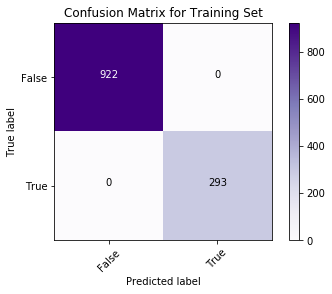

In [49]:
display_matrix(y_train, train_pred, data='Training Set', method='Decision Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.86      0.80      0.83       239
        True       0.43      0.54      0.48        65

    accuracy                           0.75       304
   macro avg       0.65      0.67      0.65       304
weighted avg       0.77      0.75      0.76       304

Validation Set Accuracy for Decision Tree: 74.67%


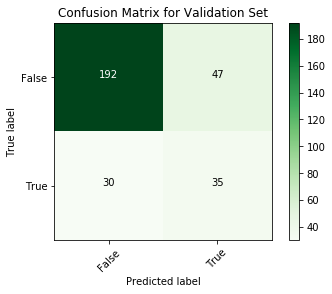

In [50]:
display_matrix(y_val, val_pred, data='Validation Set', method='Decision Tree')

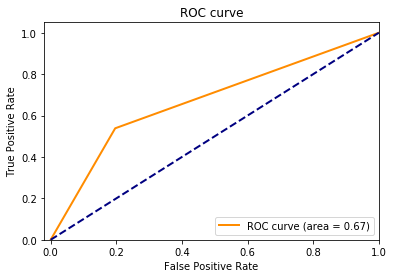

In [51]:
roc_graph(y_val, val_pred)

The results are quite bad. However, this is just a simple decision tree model.

### Pruning Tree

In [52]:
def opt_param_plot(classifier, param_name, param_range):
    
    """
    creates a graph of the AUC as a function of parameter given the range
    """
    
    train_results, test_results = get_results(classifier, param_name, param_range)
    
    plt.figure(figsize=(10,6))
    plt.plot(param_range, train_results, 'b', label='Train AUC')
    plt.plot(param_range, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel(param_name)
    plt.legend()
    plt.show()

def get_results(classifier, param_name, param_range):
    
    """
    calculates the true positive rate and false positve rate for each parameter within a list
    """
    
    train_results = []
    test_results = []
    params = [{param_name: p} for p in param_range]
    
    for param in params:
        model = classifier(criterion='entropy', **param)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = model.predict(X_val)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)
    
    return train_results, test_results
    

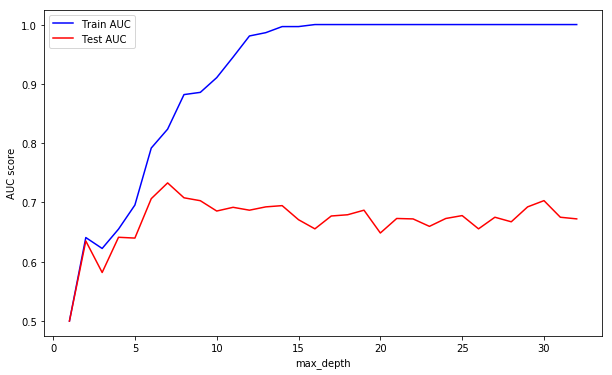

In [53]:
opt_param_plot(DecisionTreeClassifier, param_name='max_depth', param_range=np.linspace(1, 32, 32, endpoint=True))

optimal tree depth as 7

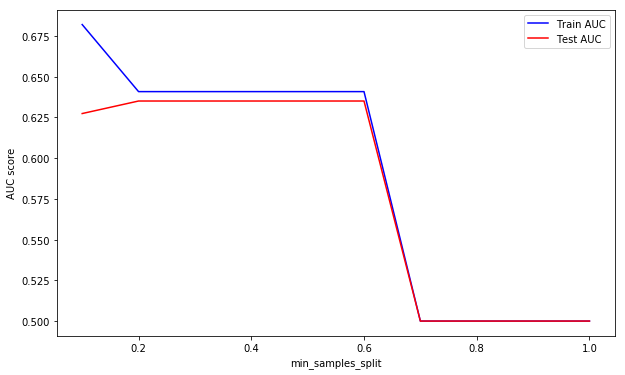

In [54]:
opt_param_plot(DecisionTreeClassifier, param_name='min_samples_split', param_range=np.linspace(0.1, 1.0, 10, endpoint=True))

optimal minimum sample split is 0.2 - 0.6

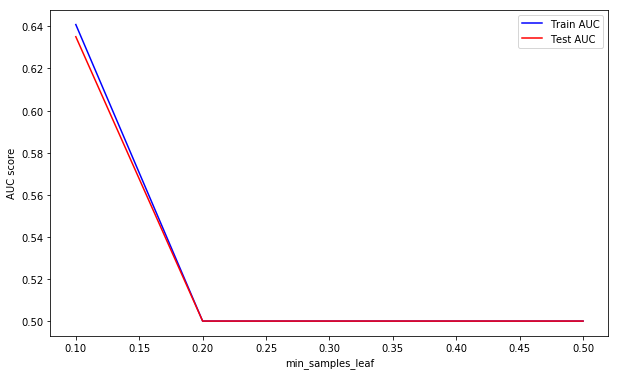

In [55]:
opt_param_plot(DecisionTreeClassifier, param_name='min_samples_leaf', param_range=np.linspace(0.1, 0.5, 5, endpoint=True))

optimal minimum sample leafs is 0.10

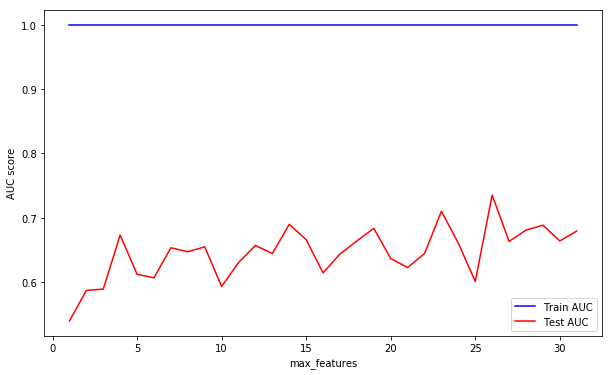

In [56]:
opt_param_plot(DecisionTreeClassifier, param_name='max_features', param_range=list(range(1,X_train.shape[1])))

optimal number of features is 20

In [57]:
# Train the classifier with optimal values identified
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=20,
                           max_depth=7,
                           min_samples_split=0.4,
                           min_samples_leaf=0.1,
                           random_state=100)
model_dt = dt.fit(X_train, y_train)
train_pred1 = dt.predict(X_train)
val_pred1 = dt.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.81      0.93      0.86       922
        True       0.57      0.31      0.41       293

    accuracy                           0.78      1215
   macro avg       0.69      0.62      0.63      1215
weighted avg       0.75      0.78      0.75      1215

Training Set Accuracy for pruned Decision Tree: 77.78%


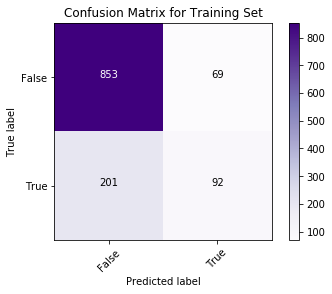

In [58]:
display_matrix(y_train, train_pred1, data='Training Set', method='pruned Decision Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.84      0.93      0.88       239
        True       0.58      0.34      0.43        65

    accuracy                           0.81       304
   macro avg       0.71      0.64      0.66       304
weighted avg       0.78      0.81      0.79       304

Validation Set Accuracy for pruned Decision Tree: 80.59%


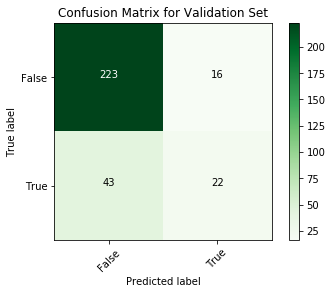

In [59]:
display_matrix(y_val, val_pred1, data='Validation Set', method='pruned Decision Tree')

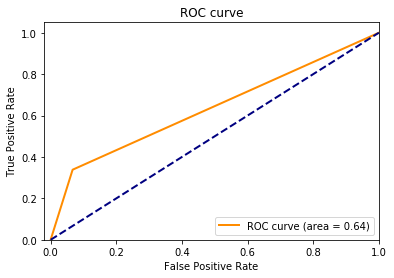

In [60]:
roc_graph(y_val, val_pred1)

Pruning the tree produced worse results. A higher number of false negative here led to a lower recall score in the validation set.

### Bagging Trees

In [61]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', 
                                max_depth=9), n_estimators=30, random_state=100)
model_bagged_tree = bagged_tree.fit(X_train, y_train)
train_pred2 = bagged_tree.predict(X_train)
val_pred2 = bagged_tree.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      1.00      0.98       922
        True       1.00      0.84      0.91       293

    accuracy                           0.96      1215
   macro avg       0.98      0.92      0.94      1215
weighted avg       0.96      0.96      0.96      1215

Training Set Accuracy for Bagged Tree: 96.13%


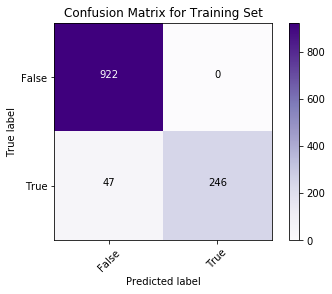

In [62]:
display_matrix(y_train, train_pred2, data='Training Set', method='Bagged Tree')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.85      0.95      0.90       239
        True       0.67      0.40      0.50        65

    accuracy                           0.83       304
   macro avg       0.76      0.67      0.70       304
weighted avg       0.81      0.83      0.81       304

Validation Set Accuracy for Bagged Tree: 82.89%


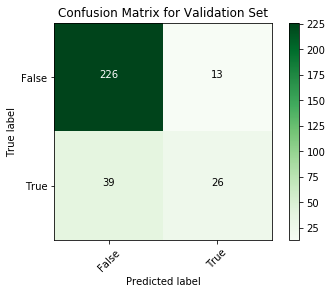

In [63]:
display_matrix(y_val, val_pred2, data='Validation Set', method='Bagged Tree')

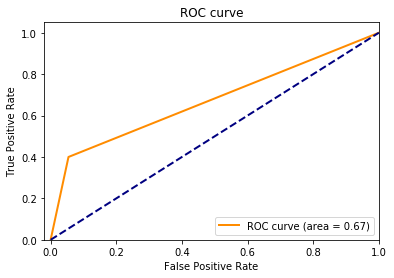

In [64]:
roc_graph(y_val, val_pred2)

This model produced similar results to the decision tree model but the recall score for the minority class in the validation set is 0.14 less here.

### Random Forest

In [65]:
rf_clf = RandomForestClassifier(max_features=23, max_depth=8, n_estimators=1000, random_state=100)
model_rf_clf = rf_clf.fit(X_train, y_train)
train_pred3 = rf_clf.predict(X_train)
val_pred3 = rf_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.93      1.00      0.97       922
        True       1.00      0.78      0.88       293

    accuracy                           0.95      1215
   macro avg       0.97      0.89      0.92      1215
weighted avg       0.95      0.95      0.94      1215

Training Set Accuracy for Random Forest: 94.65%


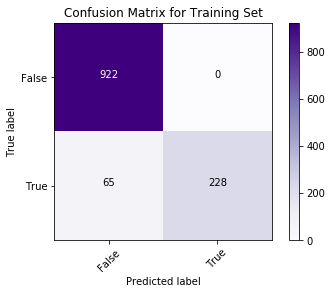

In [66]:
display_matrix(y_train, train_pred3, data='Training Set', method='Random Forest')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.84      0.96      0.90       239
        True       0.70      0.32      0.44        65

    accuracy                           0.83       304
   macro avg       0.77      0.64      0.67       304
weighted avg       0.81      0.83      0.80       304

Validation Set Accuracy for Random Forest: 82.57%


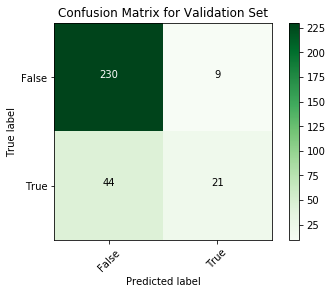

In [67]:
display_matrix(y_val, val_pred3, data='Validation Set', method='Random Forest')

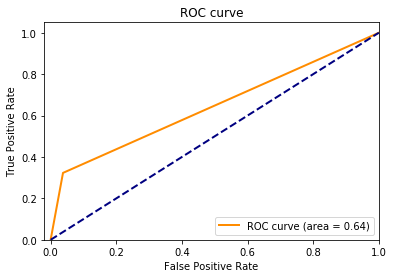

In [68]:
roc_graph(y_val, val_pred3)

It is quite surprising that the random forest model is worse than the simple decision tree model.  This model has the worst recall score for the validation set so far. Perhaps fine tuning the model would produce a better predictions.

### Random Forest with weights using GridSearchCV

In [69]:
rf_clf = RandomForestClassifier(random_state=100, class_weight={1:3, 0:1})
rf_param_grid = {
                 'n_estimators': [100, 250, 500],
                 'criterion':['entropy'],
                 'max_depth':[6, 9],
                 'max_features': [16, 23],
                 'min_samples_split':[2, 4],
                 'min_samples_leaf':[5]
                }

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
train_pred4 = rf_grid_search.predict(X_train)
val_pred4 = rf_grid_search.predict(X_val)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 79.67%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 23, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.97      0.96      0.97       922
        True       0.88      0.92      0.90       293

    accuracy                           0.95      1215
   macro avg       0.93      0.94      0.93      1215
weighted avg       0.95      0.95      0.95      1215

Training Set Accuracy for Random Forest: 95.06%


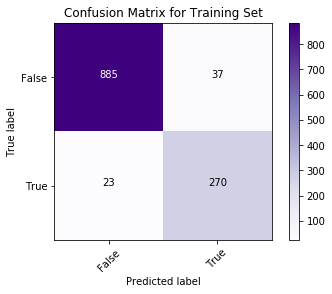

In [70]:
display_matrix(y_train, train_pred4, data='Training Set', method='Random Forest')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.92      0.90       239
        True       0.66      0.57      0.61        65

    accuracy                           0.85       304
   macro avg       0.77      0.74      0.76       304
weighted avg       0.84      0.85      0.84       304

Validation Set Accuracy for Random Forest: 84.54%


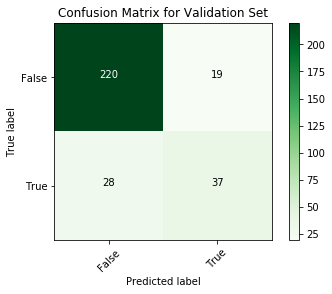

In [71]:
display_matrix(y_val, val_pred4, data='Validation Set', method='Random Forest')

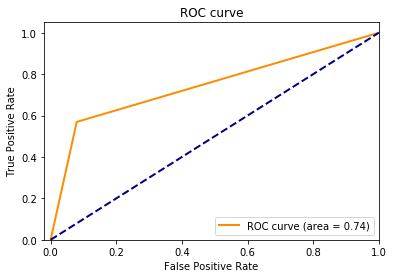

In [72]:
roc_graph(y_val, val_pred4)

The predictions are so much better. The recall score is now 0.57 compared to 0.32 for the validation set. Adding weights to the minority class also made a big difference.

### Adaboost

In [73]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight={1:3, 0:1}), n_estimators=100, learning_rate=1.4, random_state=100)
ada_model = ada_clf.fit(X_train, y_train)
ada_pred_train = ada_clf.predict(X_train)
ada_pred_val = ada_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.86      0.90       922
        True       0.66      0.86      0.75       293

    accuracy                           0.86      1215
   macro avg       0.80      0.86      0.82      1215
weighted avg       0.88      0.86      0.86      1215

Training Set Accuracy for Adaboost: 85.76%


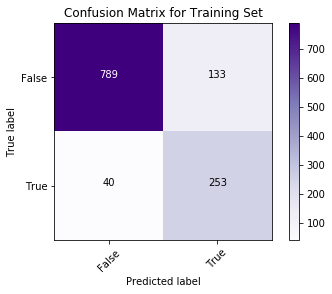

In [74]:
display_matrix(y_train, ada_pred_train, data='Training Set', method='Adaboost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.85      0.87       239
        True       0.53      0.62      0.57        65

    accuracy                           0.80       304
   macro avg       0.71      0.73      0.72       304
weighted avg       0.81      0.80      0.80       304

Validation Set Accuracy for Adaboost: 79.93%


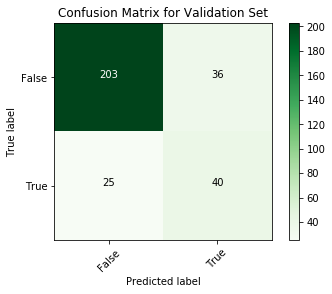

In [75]:
display_matrix(y_val, ada_pred_val, data='Validation Set', method='Adaboost')

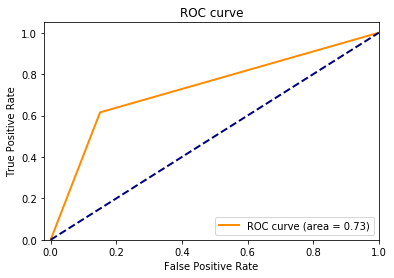

In [76]:
roc_graph(y_val, ada_pred_val)

Overall, this is a good model with a f1 score of 0.57 for the minority class and an AUC of 0.73. A relative high false positive rate reduces the precision score.

### XGBoost

In [77]:
xgb_clf = xgb.XGBClassifier(eta=0.2, max_depth=5, subsample=0.5, scale_pos_weight=2.5, min_child_weight=15, num_parallel_tree=100, random_state=100)
xgb_clf.fit(X_train, y_train)

training_preds = xgb_clf.predict(X_train)
val_preds = xgb_clf.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.91      0.93       922
        True       0.74      0.85      0.79       293

    accuracy                           0.89      1215
   macro avg       0.85      0.88      0.86      1215
weighted avg       0.90      0.89      0.90      1215

Training Set Accuracy for XGBoost: 89.3%


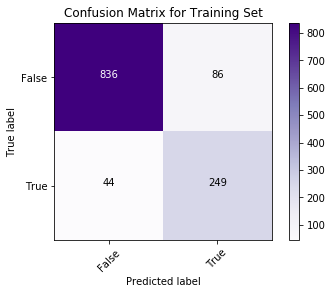

In [78]:
display_matrix(y_train, training_preds, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.88      0.89       239
        True       0.60      0.68      0.64        65

    accuracy                           0.84       304
   macro avg       0.76      0.78      0.77       304
weighted avg       0.84      0.84      0.84       304

Validation Set Accuracy for XGBoost: 83.55%


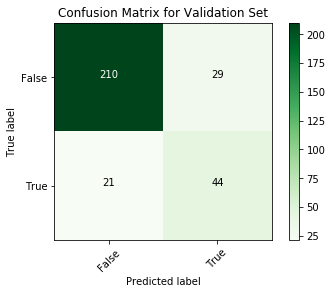

In [79]:
display_matrix(y_val, val_preds, data='Validation Set', method='XGBoost')

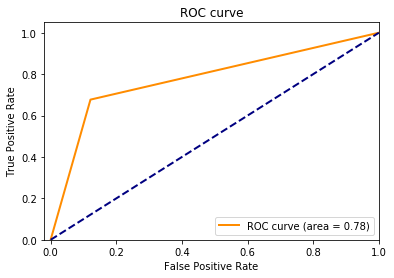

In [80]:
roc_graph(y_val, val_preds)

XGBoost gives the best predictions and is now the leading contender. Let's try to fine tune this with GridSearchCV

### XGBoost with GridSearchCV

In [81]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [7, 8],
    'min_child_weight': [12, 18],
    'subsample': [0.4, 0.5],
    'n_estimators': [100, 200]
    }

In [82]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=2.5, random_state=100)
grid_xgb_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=5, n_jobs=4)
grid_xgb_clf.fit(X_train, y_train)

best_parameters = grid_xgb_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds1 = grid_xgb_clf.predict(X_train)
val_preds1 = grid_xgb_clf.predict(X_val)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 7
min_child_weight: 12
n_estimators: 100
subsample: 0.5


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.96      0.92      0.94       922
        True       0.77      0.87      0.82       293

    accuracy                           0.91      1215
   macro avg       0.86      0.89      0.88      1215
weighted avg       0.91      0.91      0.91      1215

Training Set Accuracy for XGBoost: 90.53%


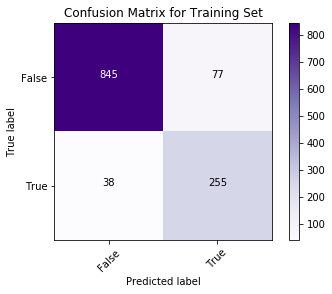

In [83]:
display_matrix(y_train, training_preds1, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.91      0.88      0.89       239
        True       0.60      0.66      0.63        65

    accuracy                           0.83       304
   macro avg       0.75      0.77      0.76       304
weighted avg       0.84      0.83      0.84       304

Validation Set Accuracy for XGBoost: 83.22%


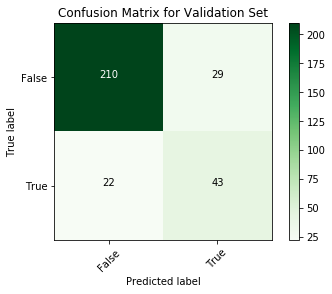

In [84]:
display_matrix(y_val, val_preds1, data='Validation Set', method='XGBoost')

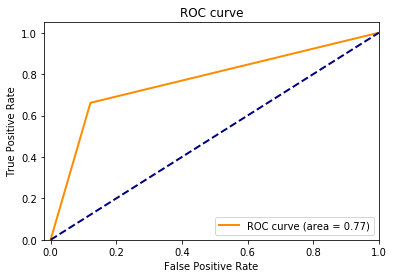

In [85]:
roc_graph(y_val, val_preds1)

GridSearchCV did not produce any better results after testing several times with different values.

## SVM

In [86]:
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=16, class_weight={1:2, 0:1}, random_state=100))])
model_svc = svc_pipeline.fit(X_train, y_train)
y_hat_train_rbf = svc_pipeline.predict(X_train)
y_hat_val_rbf = svc_pipeline.predict(X_val)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.95      0.93      0.94       922
        True       0.79      0.85      0.82       293

    accuracy                           0.91      1215
   macro avg       0.87      0.89      0.88      1215
weighted avg       0.91      0.91      0.91      1215

Training Set Accuracy for SVM: 90.95%


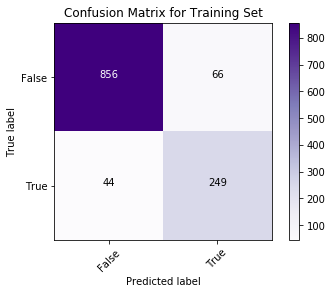

In [87]:
display_matrix(y_train, y_hat_train_rbf, data='Training Set', method='SVM')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.90      0.83      0.86       239
        True       0.51      0.65      0.57        65

    accuracy                           0.79       304
   macro avg       0.70      0.74      0.72       304
weighted avg       0.81      0.79      0.80       304

Validation Set Accuracy for SVM: 79.28%


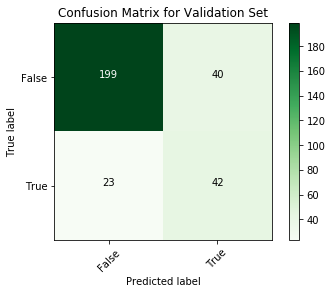

In [88]:
display_matrix(y_val, y_hat_val_rbf, data='Validation Set', method='SVM')

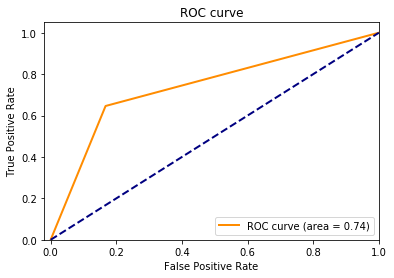

In [89]:
roc_graph(y_val, y_hat_val_rbf)

Although the AUC is decent, the high false positive rate is suppressing the precision and f1 scores in the validation set.

### SVM with GridSearchCV

In [90]:
parameters = {'svc__C':[0.1, 1, 10], 
              'svc__gamma':[0.05, 0.01],
              'svc__class_weight':[{0:1, 1:w} for w in [2, 3]]}

svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=100))])

In [91]:
grid_svm = GridSearchCV(svc_pipeline, param_grid=parameters, cv=5)
grid_svm.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(grid_svm.best_score_ * 100))
print("Optimal Parameters: {}".format(grid_svm.best_params_))

y_hat_train_rbf1 = grid_svm.predict(X_train)
y_hat_val_rbf1 = grid_svm.predict(X_val)

Testing Accuracy: 79.75%
Optimal Parameters: {'svc__C': 1, 'svc__class_weight': {0: 1, 1: 2}, 'svc__gamma': 0.05}


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.92      0.90      0.91       922
        True       0.71      0.74      0.73       293

    accuracy                           0.87      1215
   macro avg       0.81      0.82      0.82      1215
weighted avg       0.87      0.87      0.87      1215

Training Set Accuracy for SVM: 86.5%


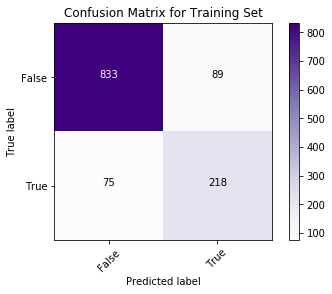

In [92]:
display_matrix(y_train, y_hat_train_rbf1, data='Training Set', method='SVM')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.88      0.89       239
        True       0.58      0.60      0.59        65

    accuracy                           0.82       304
   macro avg       0.74      0.74      0.74       304
weighted avg       0.82      0.82      0.82       304

Validation Set Accuracy for SVM: 82.24%


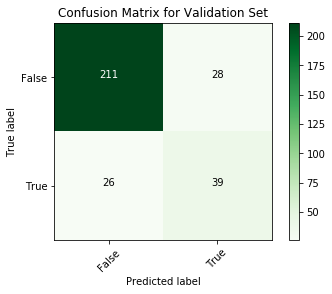

In [93]:
display_matrix(y_val, y_hat_val_rbf1, data='Validation Set', method='SVM')

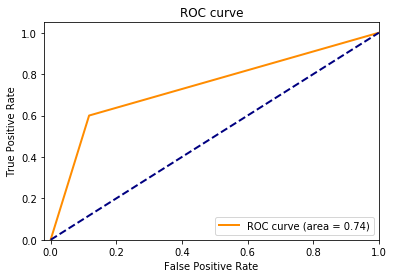

In [94]:
roc_graph(y_val, y_hat_val_rbf1)

It is a good improvement in the precision and f1 scores from the last model. The AUC results is comparable to the Random Forest model through GridSearchCV.

## Optimizing The Best of All Models

It looks like the original XGboost model is the best. Fine tuning the model with GridSearch CV did not make it better. Perhaps, changing the search algorithm to RandomizedSearchCV would be more effective.

In [95]:
param_grid = {
        'objective': ['binary:logistic'],
        'max_depth': [4, 5, 6, 7],
        'learning_rate': [0.10, 0.15, 0.20, 0.25],
        'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8],
        'colsample_bylevel': [0.2, 0.4, 0.6, 0.8],
        'min_child_weight': [15, 17, 19],
        'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
        'reg_lambda': [1.0, 5.0, 10.0, 20.0, 30.0],
        'n_estimators': [100]
        }

In [96]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=2.5)
rs_xgb_clf = RandomizedSearchCV(xgb_clf, param_grid, n_iter=1000,
            n_jobs=-1, cv=3, random_state=100)

rs_xgb_clf.fit(X_train, y_train)
best_score = rs_xgb_clf.best_score_
best_params = rs_xgb_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.7925925925925926
Best params: 
colsample_bylevel: 0.8
colsample_bytree: 0.6
gamma: 0.2
learning_rate: 0.15
max_depth: 5
min_child_weight: 17
n_estimators: 100
objective: 'binary:logistic'
reg_lambda: 5.0
subsample: 0.8


Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.97      0.92      0.94       922
        True       0.77      0.90      0.83       293

    accuracy                           0.91      1215
   macro avg       0.87      0.91      0.89      1215
weighted avg       0.92      0.91      0.91      1215

Training Set Accuracy for XGBoost: 91.28%


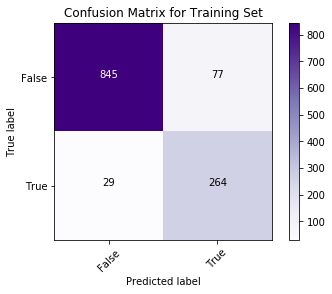

In [97]:
rs_xgb_clf = rs_xgb_clf.best_estimator_
training_predictions = rs_xgb_clf.predict(X_train)
display_matrix(y_train, training_predictions, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.89      0.89      0.89       239
        True       0.59      0.58      0.59        65

    accuracy                           0.83       304
   macro avg       0.74      0.74      0.74       304
weighted avg       0.82      0.83      0.83       304

Validation Set Accuracy for XGBoost: 82.57%


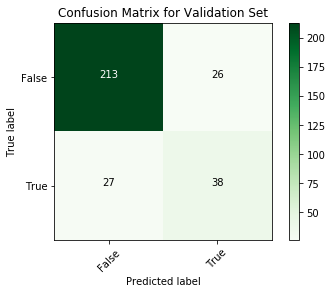

In [98]:
validation_predictions = rs_xgb_clf.predict(X_val)
display_matrix(y_val, validation_predictions, data='Validation Set', method='XGBoost')

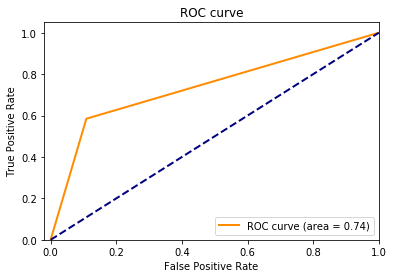

In [99]:
roc_graph(y_val, validation_predictions)

Similar results here as XGboost with GridSearchCV. Next, let's try using AutoML, specifically with Tpot, to find the best model and parameters for the train set.

In [36]:
client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:50366 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 34.36 GB


In [44]:
pipeline_optimizer = TPOTClassifier(generations=50, population_size=100, cv=5, scoring='balanced_accuracy',
                                    random_state=100, verbosity=2, n_jobs=-1, use_dask=True)
pipeline_optimizer.fit(X_train, y_train)
training_predictions1 = pipeline_optimizer.predict(X_train)
validation_predictions1 = pipeline_optimizer.predict(X_val)

Generation 1 - Current best internal CV score: 0.6725005683141022
Generation 2 - Current best internal CV score: 0.6725005683141022
Generation 3 - Current best internal CV score: 0.6975783930068864
Generation 4 - Current best internal CV score: 0.6975783930068864
Generation 5 - Current best internal CV score: 0.6975783930068864
Generation 6 - Current best internal CV score: 0.6975783930068864
Generation 7 - Current best internal CV score: 0.6984118625524618
Generation 8 - Current best internal CV score: 0.7126519630702285
Generation 9 - Current best internal CV score: 0.7215542360519237
Generation 10 - Current best internal CV score: 0.7215542360519237
Generation 11 - Current best internal CV score: 0.7376038263506818
Generation 12 - Current best internal CV score: 0.7376038263506818
Generation 13 - Current best internal CV score: 0.7376038263506818
Generation 14 - Current best internal CV score: 0.7376038263506818
Generation 15 - Current best internal CV score: 0.7376038263506818
Gene

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.99      0.81      0.89       922
        True       0.62      0.96      0.75       293

    accuracy                           0.85      1215
   macro avg       0.80      0.89      0.82      1215
weighted avg       0.90      0.85      0.86      1215

Training Set Accuracy for TPOT: 84.86%


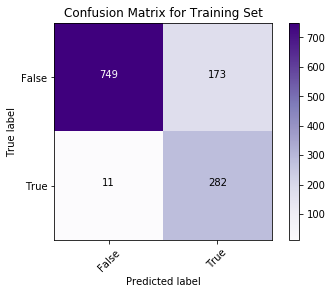

In [47]:
display_matrix(y_train, training_predictions1, data='Training Set', method='TPOT')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.93      0.74      0.83       239
        True       0.46      0.78      0.58        65

    accuracy                           0.75       304
   macro avg       0.69      0.76      0.70       304
weighted avg       0.83      0.75      0.77       304

Validation Set Accuracy for TPOT: 75.33%


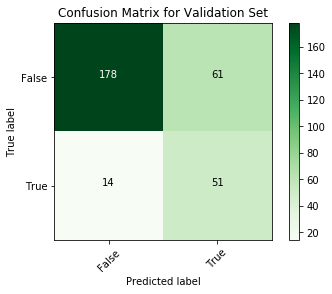

In [48]:
display_matrix(y_val, validation_predictions1, data='Validation Set', method='TPOT')

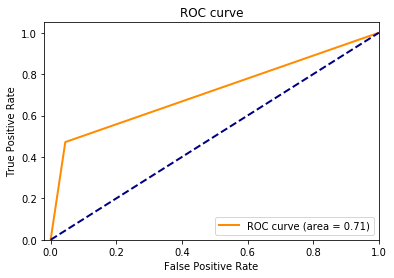

In [49]:
roc_graph(y_test, testing_predictions1)

That is quite surprising that the extremely complex model that Tpot created to be the best estimator performed worse than the model Randomized Search selected on the validation set. The top 2 models, as it stands, are Logistic Regression with weights and the original XGBoost model. However, as XGBoost model has slightly better scores for the minority class for the validation set, it will be the final model that is going to be retrained on a larger set and validated on the test set.

In [100]:
optimized_xgb = xgb_clf
optimized_xgb.fit(X_cv, y_cv)

training_prediction = optimized_xgb.predict(X_cv)
testing_prediction = optimized_xgb.predict(X_test)

Classification Report for Training Set:

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1161
        True       0.76      0.88      0.82       358

    accuracy                           0.91      1519
   macro avg       0.86      0.90      0.88      1519
weighted avg       0.91      0.91      0.91      1519

Training Set Accuracy for XGBoost: 90.65%


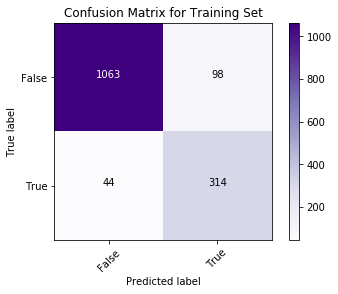

In [101]:
display_matrix(y_cv, training_prediction, data='Training Set', method='XGBoost')

Classification Report for Validation Set:

              precision    recall  f1-score   support

       False       0.90      0.87      0.89       291
        True       0.62      0.69      0.65        89

    accuracy                           0.83       380
   macro avg       0.76      0.78      0.77       380
weighted avg       0.84      0.83      0.83       380

Validation Set Accuracy for XGBoost: 82.89%


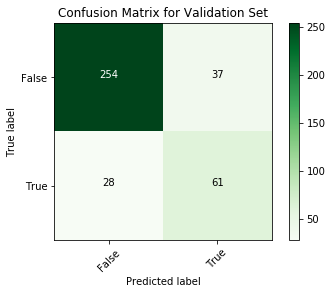

In [102]:
display_matrix(y_test, testing_prediction, data='Test Set', method='XGBoost')

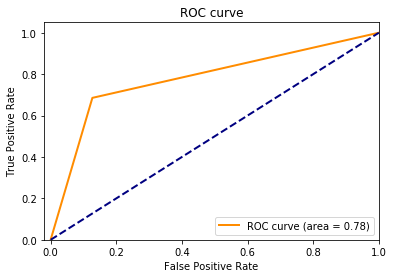

In [103]:
roc_graph(y_test, testing_prediction)

The predictions are pretty consistent and the precision, recall and f1 scores for the minority class are holding up well in the testing set. Let's examine this model with SHAP how each feature contribute to determining the predicted value(the probability of success).

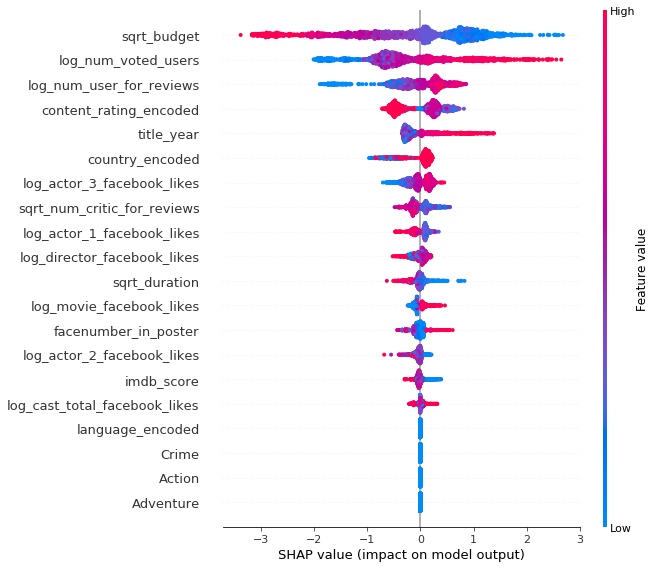

In [156]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(optimized_xgb)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)

The above graph uses the SHAP values of each feature of every sample to show the impact of each feature on the probability of the target is distributed. SHAP values represent the feature's responsibility for the change in the output probability. The plot is sorted by the sum of the SHAP value magnitudes with the colors represent the amount. The graph shows that having a high budget diminishes the probability of being a successful movie and having high log number of voted users increase that probability.

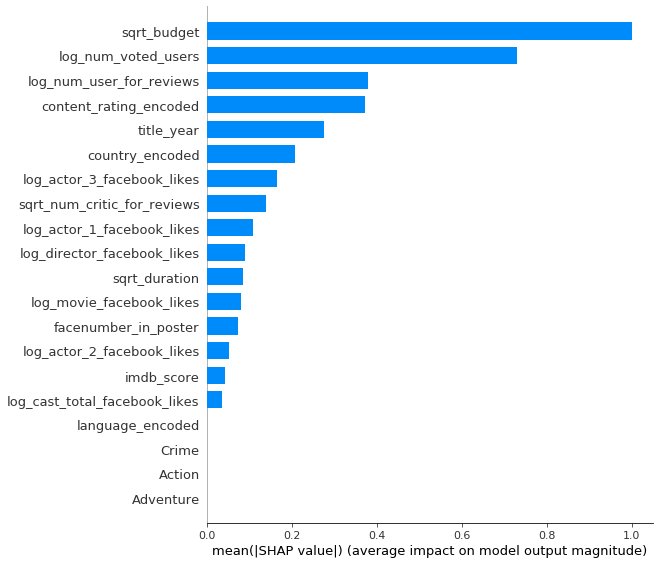

In [157]:
shap.summary_plot(shap_values, X, plot_type="bar")

The bar plot depicts the mean absolute value of the each feature's SHAP values.

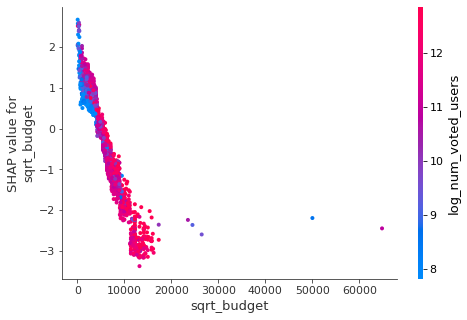

In [159]:
shap.dependence_plot("sqrt_budget", shap_values, X)

The dependence plot above does not tell much about how another feature like log_num_voted_users affect the SHAP value for sqrt_budget. 

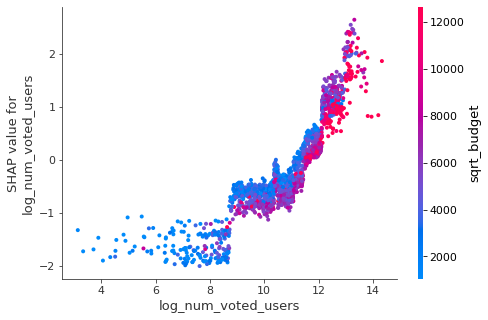

In [160]:
shap.dependence_plot("log_num_voted_users", shap_values, X)

This dependence plot tell the story from a different angle. However, there is no pattern that shows how sqrt_budget affect log_num_voted_users' SHAP values.

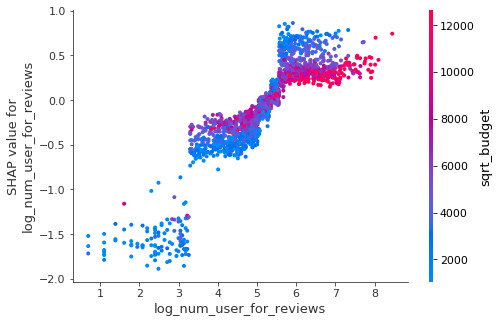

In [161]:
shap.dependence_plot("log_num_user_for_reviews", shap_values, X)

This plot reveals that a high sqrt_budget may lower the probability of movie's success even for movies with high log_num_user_for_reviews.